## Calculate the Success, Crop and Miss rates and the accuracy of the output of the whole image segmentation algorithm

In [46]:
import os
import pandas as pd
import cv2
import numpy as np
import math
import xml.dom.minidom
import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from PIL import Image
from glob import glob

## Functions

In [47]:
def create_dir(dirname):
    try:
        os.mkdir(dirname)
    except OSError:
        print ("Creation of the directory %s failed" % dirname)
    else:
        print ("Successfully created the directory %s " % dirname)

In [48]:
def ver_analysis(ecrop, count):
    
    # Create the projection signature and binary signal
    cv2.imwrite(crp_analysis_dir + str(count) + '.png', ecrop)
    esig = np.sum(ecrop, axis=1)/255

    bin_sig = []
    peaks = []
    p = []
    #Check for peaks, form binary signal, store pixel values for peak and append to peaks.
    for n in range(len(esig)):
        if esig[n] >= 2:
            bin_sig.append(5)
            p.append(n)
            if n == len(esig)-1:
                peaks.append(p)
        else:
            bin_sig.append(0)
            if len(p) != 0:
                peaks.append(p)
                p = []
            else:
                continue

    # Filter signal (Remove unlikely peaks)
    indicies = []
    for x in range(len(peaks)):
        peak = peaks[x]
        if len(peak) < 15:
            #print("Region " + str(x) + " needs to be removed")
            for y in range(len(peak)):
                bin_sig[peak[y]] = 0
            indicies.append(x)
        else:
            continue

    # Pop the false peaks from the largest index first
    indicies.reverse()
    for x in indicies:
        peaks.pop(x)

    # Plot and show the projection signature and binary signal
    plt.plot(esig, label="Projection signature")
    plt.plot(bin_sig, label="Binary signal", linestyle="dashed")
    plt.xlabel("Row")
    plt.ylabel("Row sum of pixel values)")
    plt.legend()
    plt.title("Row sum of pixel values vs row")
    plt.savefig(crp_analysis_dir + str(count) +  'v.svg')
    plt.show()
    
    return bin_sig

In [49]:
def hor_analysis(ecrop, count):
    # Create projection signture and binary signal in horizontal direction
    esig = np.sum(ecrop, axis=0)/255

    bin_sig = []
    peaks = []
    p = []
    #Check for peaks, form binary signal, store pixel values for peak and append to peaks.
    for n in range(len(esig)):
        if esig[n] >= 2:
            bin_sig.append(5)
            p.append(n)
            if n == len(esig)-1:
                peaks.append(p)
        else:
            bin_sig.append(0)
            if len(p) != 0:
                peaks.append(p)
                p = []
            else:
                continue

    # Filter signal (Remove unlikely peaks)
    indicies = []
    for x in range(len(peaks)):
        peak = peaks[x]
        if len(peak) < 15:
            #print("Region " + str(x) + " needs to be removed")
            for y in range(len(peak)):
                bin_sig[peak[y]] = 0
            indicies.append(x)
        else:
            continue

    # Pop the false peaks from the largest index first
    indicies.reverse()
    for x in indicies:
        peaks.pop(x)

    # Plot and show the projection signature and binary signal
    plt.plot(esig, label="Projection signature")
    plt.plot(bin_sig, label="Binary signal", linestyle="dashed")
    plt.xlabel("Column")
    plt.ylabel("Column sum of pixel values)")
    plt.legend()
    plt.title("Column sum of pixel values vs column")
    plt.savefig(crp_analysis_dir + str(count) +  'h.svg')
    plt.show()
    
    return bin_sig

In [50]:
def rate_crop_analyse(img, ogimg, index, gtruth, gregions):
    # Counting variables
    misses = 0
    count = 0
    cropped = 0
    succ = 0
    crop7089 = 0
    crop6069 = 0
    crop159 = 0
    
    
    if index == len(gtruth):
        # This is the case when the page has no merchant marks in the ground truth
        pass
    else:
        
        # Calculate the percentage overlap (overlap region/ground truth)
        for region in gregions:
            Tpos = 0
            overlap = []
            for x in range(region[0],region[0]+region[2]):
                for y in range(region[1],region[1]+region[3]):
                    if img[y][x] == 3:
                        Tpos += 1
                        overlap.append([y,x])
            
            percent = Tpos/(region[2]*region[3]) * 100

            #Check for a miss
            if percent == 0:
                misses += 1
            #Check if successfully extracted            
            elif percent < 90:
                # Projection signature analysis in row direction (Vertical crop)

                #Get the overlap area coordinates
                overlap = np.array(overlap)
                top = overlap.max(axis=0)[0]
                bottom = overlap.min(axis=0)[0]
                left = overlap.min(axis=0)[1]
                right = overlap.max(axis=0)[1]
                
                #Create an edge image of the overlap area
                edges = cv2.Canny(ogimg,100,200)
                ecrop = edges[bottom:top, left:right]
                
                #The case where only 1 line of pixels overlap (Most likely an accident, hence a miss)
                if ecrop.shape[0] == 0 or ecrop.shape[1] == 0:
                    misses += 1
                    continue
                
                # Create the projection signature and binary signal
                vbin_sig = ver_analysis(ecrop, count)
                
                # Check if not cropped in the vertical direction
                if vbin_sig[0] == 0 and vbin_sig[-1] == 0:
                    # Analysis in the horizontal direction
                    
                    hbin_sig = hor_analysis(ecrop, count)
                    
                    # Check for cropping in the horizontal
                    if hbin_sig[0] == 0 and hbin_sig[-1] == 0:
                        # Successful
                        succ += 1
                    else:
                        # Cropped in the horizontal
                        cropped += 1
                        print("Ground truth region " + str(count) +" cropped horizontally")
                        print("The coverage is: " + str(percent))
                        if percent < 60:
                            crop159 += 1
                        elif percent < 70:
                                crop6069 += 1
                        else:
                            crop7089 += 1
                    
                else:
                    # Was cropped in the vertical direction
                    cropped += 1
                    print("Ground truth region " + str(count) +" cropped vertically")
                    print("The coverage is: " + str(percent))
                    if percent < 60:
                        crop159 += 1
                    elif percent < 70:
                            crop6069 += 1
                    else:
                        crop7089 += 1
                
            else:
                # Was successfully extracted
                #print("Ground truth region " + str(count) +" extracted successfully")
                succ += 1
                    
            count += 1
    
    return succ, cropped, misses, crop7089, crop6069, crop159

In [51]:
def accuracy(regions):
    # Count how many regions are correct
    correct = 0
    count = 0
    for region in regions:
        r = False
        for x in range(region[0][0],region[1][0]):
            for y in range(region[1][1],region[2][1]):
                if img[y][x] == 3:
                    r = True
        if r == True:
            correct += 1
        else:
            #print("Output Region " + str(count) + " is not a mark")
            pass
        count += 1
    print(str(len(regions) - correct) + " are not marks")
    
    return correct

In [52]:
def init_metrics():
    # Initialise lists and counting variables

    # These lists will be used to calculate the av metrics
    # Rate metrics
    gmetrics = []
    # Accuracy metrics
    ometrics = []
    # Files which cause anomalies
    anomalies = []

    # These lists will be used to create the CSV file
    gdb = []
    odb = []
    rdb = []

    # Counter variables for the total number of ground truth regions and output regions
    totalgm = 0
    totalor = 0

    # Lists to contain the number of cropped regions with percentage overlap over 70-89,60-69 and 1-59
    crop70 = []
    crop60 = []
    crop1 = []
    
    return gmetrics, ometrics, anomalies, gdb, odb, rdb, totalgm, totalor, crop70, crop60, crop1

## Selecting directories to analyse and store outputs

In [53]:
# Directories and create folders

folder = "753_1588848"
analysis_dir = "../../Outputs/MM_seg/" + folder + "/analysis/"
db_dir = "../../Outputs/MM_seg/" + folder + "/DB/"
reg_dir = "../../Outputs/MM_seg/" + folder + "/model_output_regions/"

## Extract the groundtruth

In [54]:
# Extract Groundtruth data

# Load up the markup co-ordinates
# Load the ground truth csv file
via_export = pd.read_csv("../../MarkupFromVIA/marks_markup/via_export_csv.csv")
factor = 1
# Create the empty arrays
gtruth = []
page = []
regions = []
curname = ""
# Cycle through each instance of a mark
for x in range(via_export.shape[0]):
    
    # Extract the file name and region properties
    data = via_export.iloc[x]
    
    if data.filename[:-4] == curname:
        
        # reg_properties = [x,y,width,height] where x,y are the bottom left co-ordinates
        reg_properties = []
        temp_shape_data = data.region_shape_attributes[1:-1].split(',')

        # Check that the image actually has a reg
        if len(temp_shape_data) < 5:
            continue
        else:
            for y in range(1,5):
                value = temp_shape_data[y].split(':')

                # Take into account the images have been resized and floor the values
                reg_properties.append(math.floor(int(value[1])*factor))

            # Append new region to regions list
            regions.append(reg_properties)
        
        if x == via_export.shape[0]-1:
            page.append(regions)
            gtruth.append(page)
        
    else:
        page.append(regions)
        gtruth.append(page)
        page = []
        regions = []
        temp_name = data.filename.split('.')
        curname = temp_name[0]
        page.append(curname)
        page.append(data.region_count)

        # reg_properties = [x,y,width,height] where x,y are the bottom left co-ordinates
        reg_properties = []
        temp_shape_data = data.region_shape_attributes[1:-1].split(',')

        # Check that the image actually has a reg
        if len(temp_shape_data) < 5:
            continue
        else:
            for y in range(1,5):
                value = temp_shape_data[y].split(':')

                # Take into account the images have been resized and floor the values
                reg_properties.append(math.floor(int(value[1])*factor))

            # Append new region to regions list
            regions.append(reg_properties)
            if x == via_export.shape[0]-1:
                page.append(regions)
                gtruth.append(page)
            
gtruth.pop(0)

[[]]

In [55]:
# Check Groundtruth collected properly

c = 0
ok = True
for page in gtruth:
    print("\nThe filename: " + page[0])
    print("The file should have " + str(page[1]) + " regions")
    print("It has " + str(len(page[2])) + " regions\n")
    
    print(page)
    
    c = c + len(page[2])
    if page[1] != len(page[2]):
        ok = False
    else:
        continue
    
print("The total number of regions is " + str(c))
print("The CSV was processed properly: " + str(ok))


The filename: 94_20_0026
The file should have 4 regions
It has 4 regions

['94_20_0026', 4, [[616, 6103, 336, 182], [611, 6329, 402, 154], [726, 6476, 198, 70], [719, 6259, 180, 70]]]

The filename: 94_20_0027
The file should have 19 regions
It has 19 regions

['94_20_0027', 19, [[644, 704, 187, 171], [881, 875, 237, 171], [649, 1013, 231, 187], [936, 1183, 149, 187], [671, 1381, 220, 176], [969, 1530, 264, 176], [660, 1701, 275, 165], [870, 1888, 187, 154], [622, 2053, 264, 171], [897, 2207, 198, 143], [682, 2361, 187, 171], [655, 3071, 358, 182], [660, 3610, 341, 165], [671, 3803, 352, 165], [710, 4139, 286, 198], [671, 4353, 187, 198], [660, 4827, 198, 215], [682, 5355, 319, 209], [671, 5861, 314, 242]]]

The filename: 94_20_0028
The file should have 10 regions
It has 10 regions

['94_20_0028', 10, [[638, 996, 264, 171], [611, 1216, 286, 149], [578, 1381, 308, 154], [583, 1866, 237, 209], [633, 2680, 171, 242], [594, 3049, 286, 209], [578, 3946, 281, 220], [605, 4452, 275, 242], [5

## Extract the output data of image segmentation algorithm

In [56]:
# Extract output DB data

# Load the DB CSV
via_export = pd.read_csv(db_dir + "outputDB.csv")
# Create the empty arrays
output = []
page = []
regions = []
curname = ""
# Cycle through each instance of a mark
for x in range(via_export.shape[0]):
    print(x)
    
    # Extract the file name and region properties
    data = via_export.iloc[x]
    
    print(data)
    
    if data.filename == curname:
        # region = (bl, br, tr, tl)
        temp = data.co_ordinates[1:-1].split('), ')
        region = []
        for y in range(4):
            ordinates = temp[y].split(', ')
            if y == 3:
                column = int(ordinates[0][1:])
                row = int(ordinates[1][:-1])
                region.append((column, row))
            else:
                column = int(ordinates[0][1:])
                row = int(ordinates[1])
                region.append((column, row))  

        # Append new region to regions list
        regions.append(region)
        
        if x == via_export.shape[0]-1:
            page.append(regions)
            output.append(page)
    else:
        page.append(regions)
        output.append(page)
        page = []
        regions = []
        curname = data.filename
        page.append(curname)

        # region = (bl, br, tr, tl)
        temp = data.co_ordinates[1:-1].split('), ')
        region = []
        for y in range(4):
            ordinates = temp[y].split(', ')
            if y == 3:
                column = int(ordinates[0][1:])
                row = int(ordinates[1][:-1])
                region.append((column, row))
            else:
                column = int(ordinates[0][1:])
                row = int(ordinates[1])
                region.append((column, row))
        regions.append(region)
        
        if x == via_export.shape[0]-1:
            page.append(regions)
            output.append(page)
            
output.pop(0)
print(output)

0
Unnamed: 0                                                      0
filename                                              113_21_0057
mark_id                                                     mark0
co_ordinates    [(1163, 4265), (1557, 4265), (1557, 4515), (11...
Name: 0, dtype: object
1
Unnamed: 0                                                      1
filename                                              113_21_0057
mark_id                                                     mark1
co_ordinates    [(1431, 3512), (1473, 3512), (1473, 3554), (14...
Name: 1, dtype: object
2
Unnamed: 0                                                      2
filename                                               114_7_0076
mark_id                                                     mark2
co_ordinates    [(901, 2562), (1217, 2562), (1217, 2714), (901...
Name: 2, dtype: object
3
Unnamed: 0                                                      3
filename                                               114_7_0076

## Calculate "rate" metrics and accuracy

Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/113_21_0057 failed
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/113_21_0057/crop_analysis/ failed

Analysing 113_21_0057
Loading output
Loading Gtruth
Calculating the rate and crop metrics
0 missed
0 cropped
1 successes

The total number of 70-89 crops: 0
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0
Calculating the # of false marks
1 are not marks
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/114_7_0076 failed
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/114_7_0076/crop_analysis/ failed

Analysing 114_7_0076
Loading output
Loading Gtruth
Calculating the rate and crop metrics


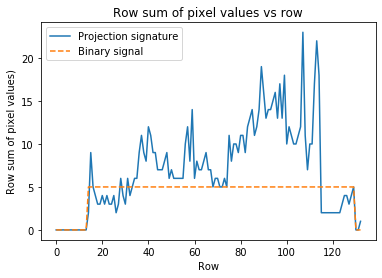

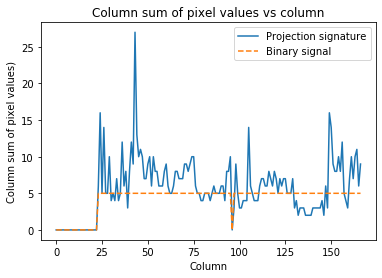

Ground truth region 0 cropped horizontally
The coverage is: 61.6800920598389


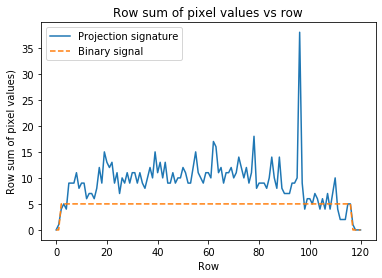

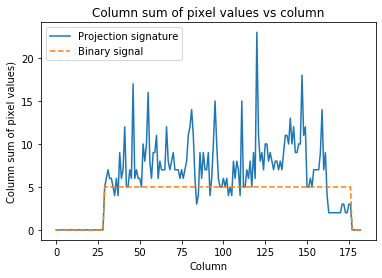

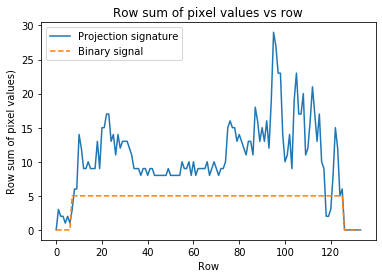

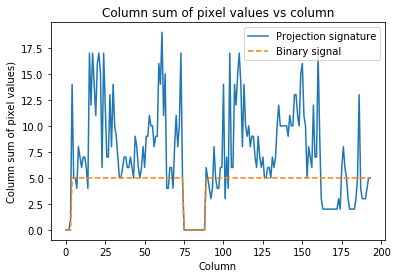

Ground truth region 4 cropped horizontally
The coverage is: 75.12842465753424


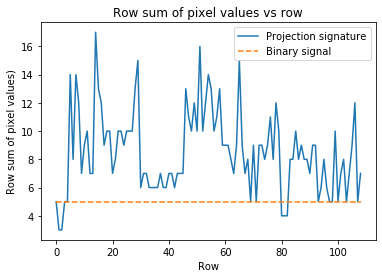

Ground truth region 5 cropped vertically
The coverage is: 51.76470588235295


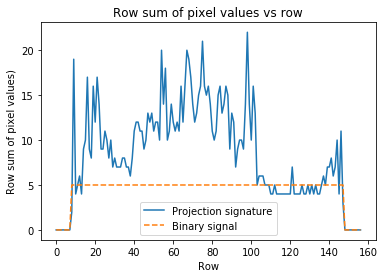

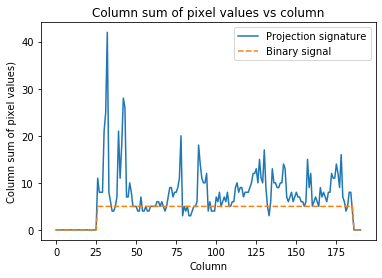

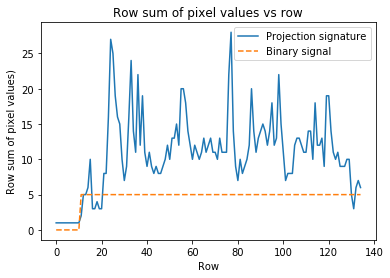

Ground truth region 10 cropped vertically
The coverage is: 85.42521192234072
0 missed
4 cropped
8 successes

The total number of 70-89 crops: 2
The total number of 60-69 crops: 1
The total number of 1-59 crops: 1
Calculating the # of false marks
27 are not marks
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/105_11_0076 failed
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/105_11_0076/crop_analysis/ failed

Analysing 105_11_0076
Loading output
Loading Gtruth
Calculating the rate and crop metrics


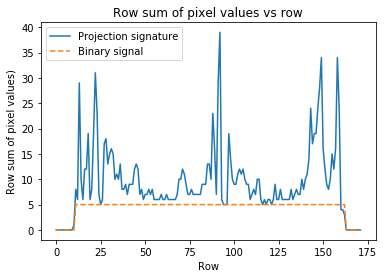

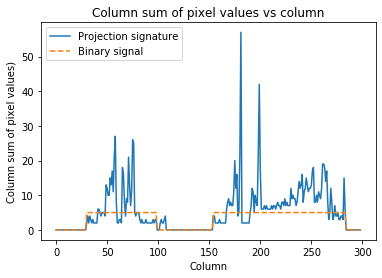

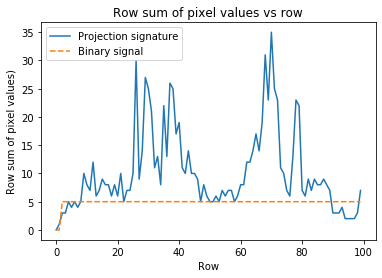

Ground truth region 3 cropped vertically
The coverage is: 84.87394957983193


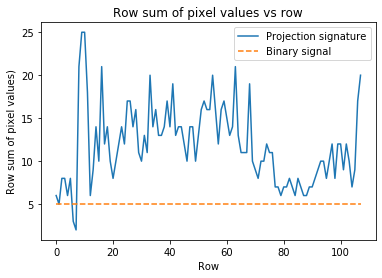

Ground truth region 4 cropped vertically
The coverage is: 58.82504111842105


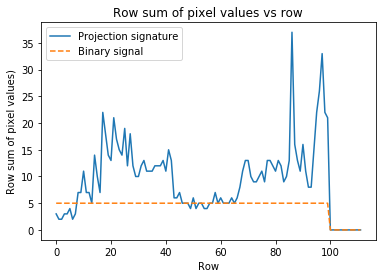

Ground truth region 6 cropped vertically
The coverage is: 88.28125


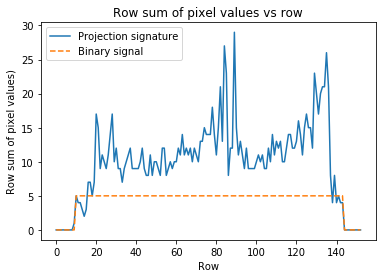

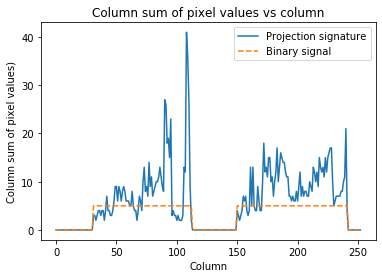

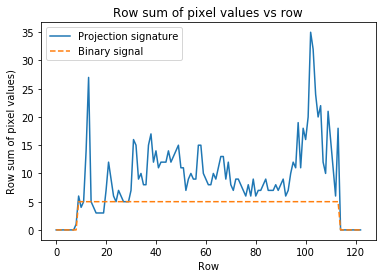

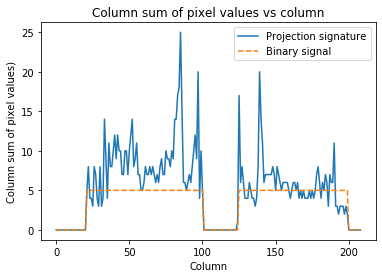

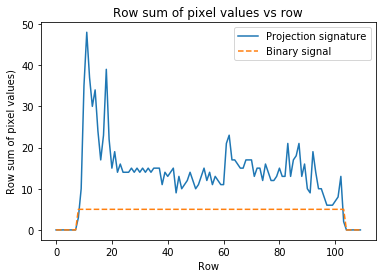

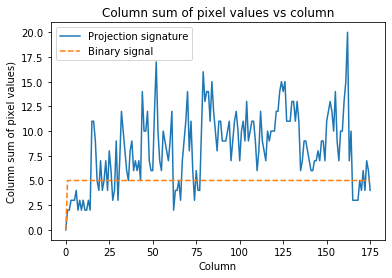

Ground truth region 10 cropped horizontally
The coverage is: 72.76666666666667


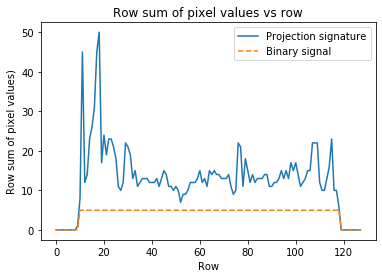

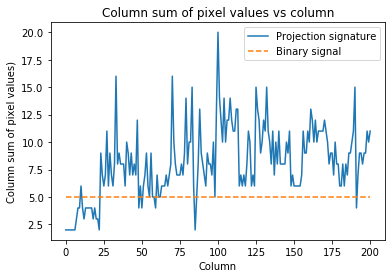

Ground truth region 12 cropped horizontally
The coverage is: 82.69755633132338
1 missed
5 cropped
9 successes

The total number of 70-89 crops: 4
The total number of 60-69 crops: 0
The total number of 1-59 crops: 1
Calculating the # of false marks
0 are not marks
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/114_7_0078 failed
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/114_7_0078/crop_analysis/ failed

Analysing 114_7_0078
Loading output
Loading Gtruth
Calculating the rate and crop metrics


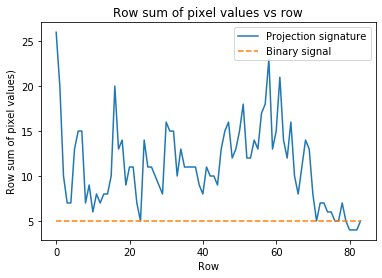

Ground truth region 1 cropped vertically
The coverage is: 41.2705418986826


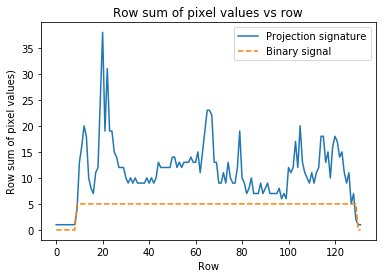

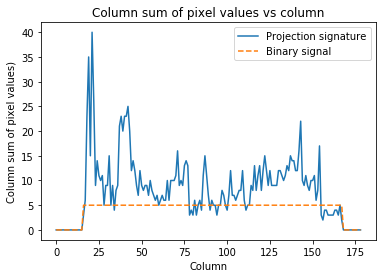

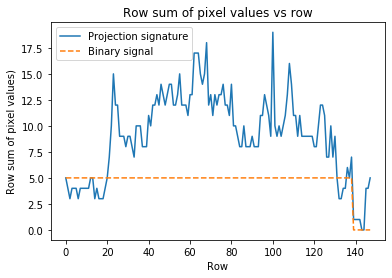

Ground truth region 5 cropped vertically
The coverage is: 78.6889818688982


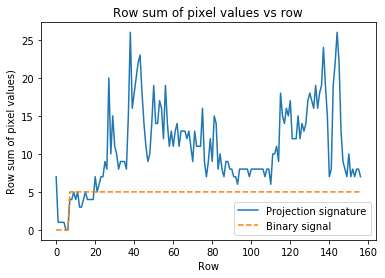

Ground truth region 6 cropped vertically
The coverage is: 87.29941194059603


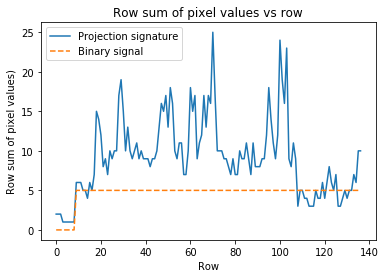

Ground truth region 7 cropped vertically
The coverage is: 87.34177215189874


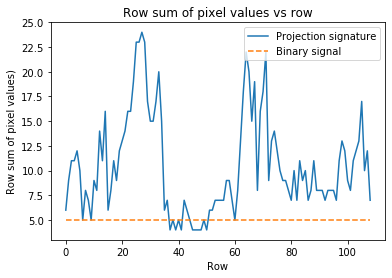

Ground truth region 8 cropped vertically
The coverage is: 52.202000555709915


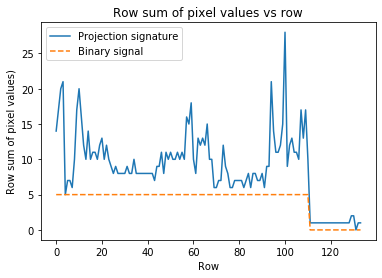

Ground truth region 9 cropped vertically
The coverage is: 82.55333674688514


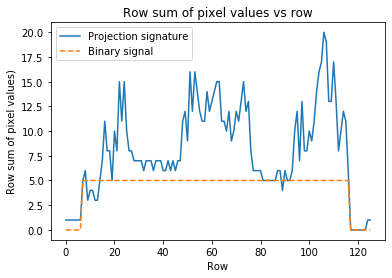

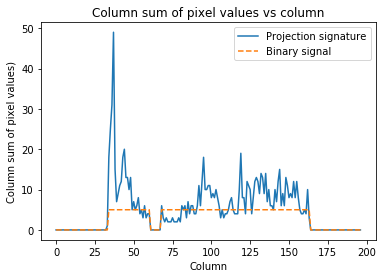

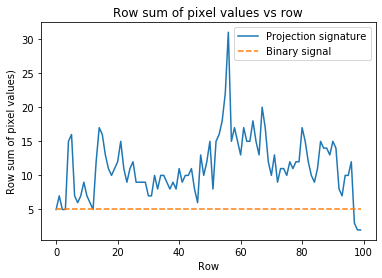

Ground truth region 11 cropped vertically
The coverage is: 44.971353842321584


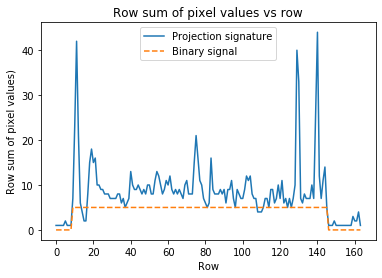

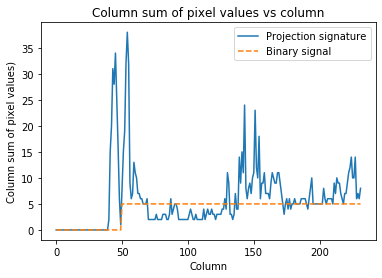

Ground truth region 14 cropped horizontally
The coverage is: 81.60125237616013


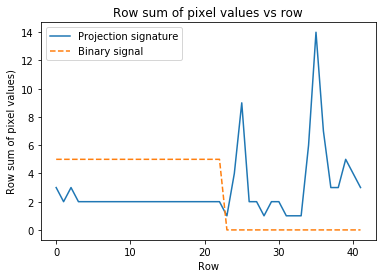

Ground truth region 19 cropped vertically
The coverage is: 6.033610703214228


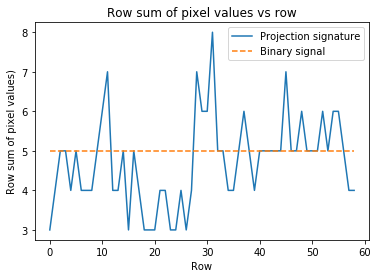

Ground truth region 20 cropped vertically
The coverage is: 21.911922663802365


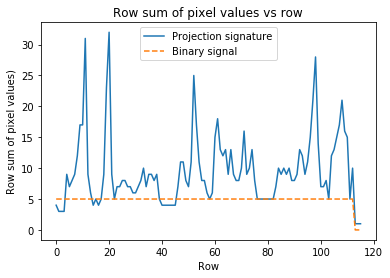

Ground truth region 21 cropped vertically
The coverage is: 71.61016949152543


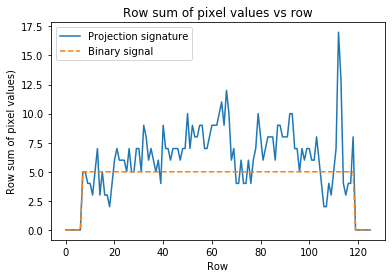

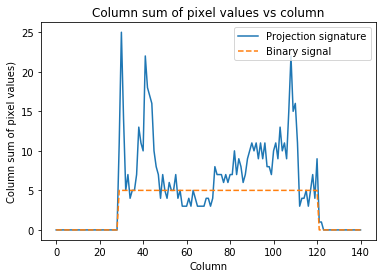

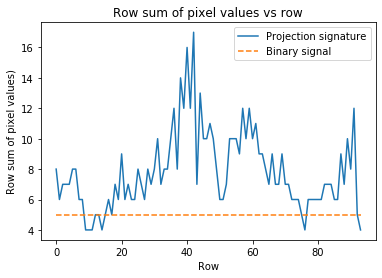

Ground truth region 26 cropped vertically
The coverage is: 67.28797763280522


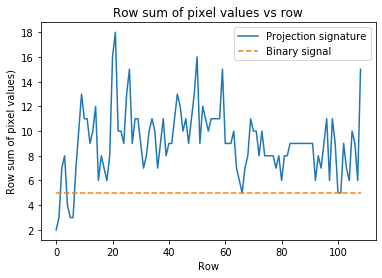

Ground truth region 27 cropped vertically
The coverage is: 65.71691176470588


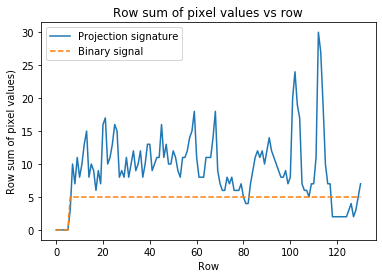

Ground truth region 32 cropped vertically
The coverage is: 88.0


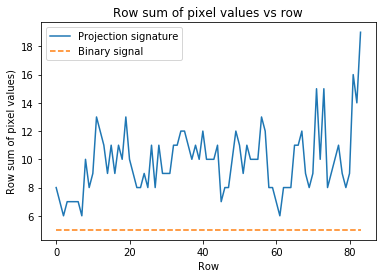

Ground truth region 35 cropped vertically
The coverage is: 75.22123893805309


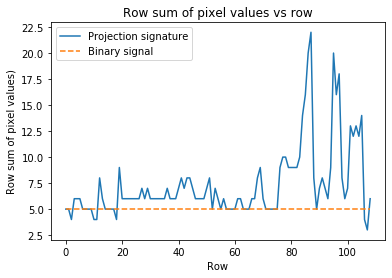

Ground truth region 37 cropped vertically
The coverage is: 50.69989757596449
1 missed
16 cropped
21 successes

The total number of 70-89 crops: 8
The total number of 60-69 crops: 2
The total number of 1-59 crops: 6
Calculating the # of false marks
0 are not marks
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/105_11_0105 failed
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/105_11_0105/crop_analysis/ failed

Analysing 105_11_0105
Loading output
Loading Gtruth
Calculating the rate and crop metrics


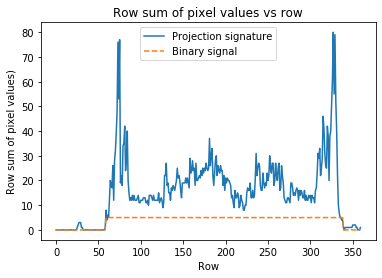

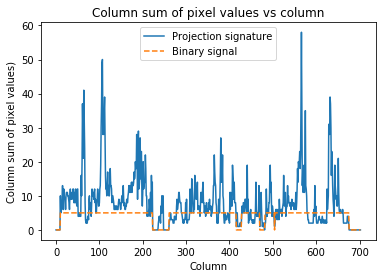

0 missed
0 cropped
1 successes

The total number of 70-89 crops: 0
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0
Calculating the # of false marks
0 are not marks
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/105_11_0117 failed
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/105_11_0117/crop_analysis/ failed

Analysing 105_11_0117
Loading output
Loading Gtruth
Calculating the rate and crop metrics


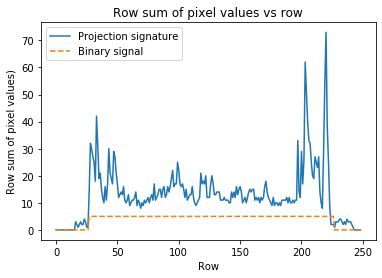

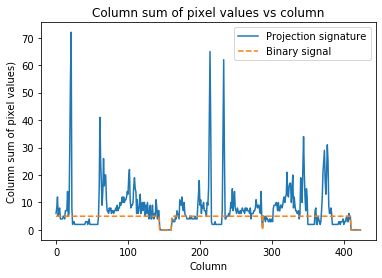

Ground truth region 0 cropped horizontally
The coverage is: 76.31750957111355
0 missed
1 cropped
0 successes

The total number of 70-89 crops: 1
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0
Calculating the # of false marks
0 are not marks
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/105_11_0077 failed
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/105_11_0077/crop_analysis/ failed

Analysing 105_11_0077
Loading output
Loading Gtruth
Calculating the rate and crop metrics


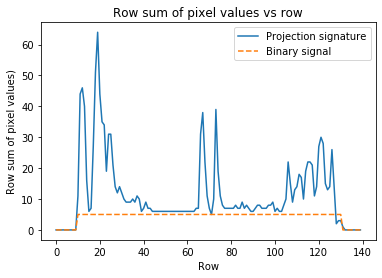

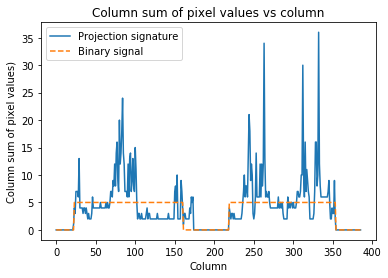

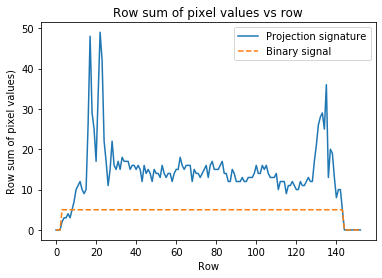

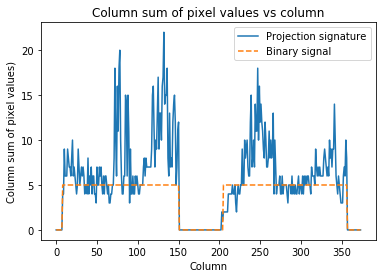

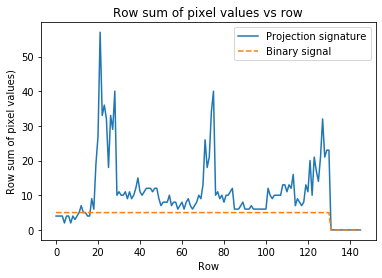

Ground truth region 4 cropped vertically
The coverage is: 77.03655844505465


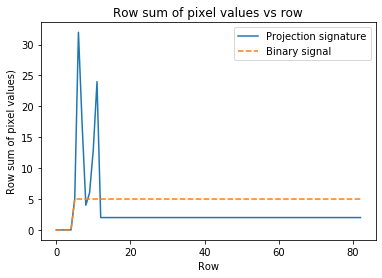

Ground truth region 5 cropped vertically
The coverage is: 8.92018779342723


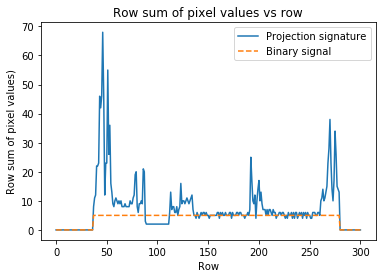

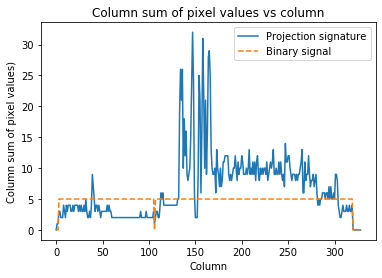

0 missed
2 cropped
5 successes

The total number of 70-89 crops: 1
The total number of 60-69 crops: 0
The total number of 1-59 crops: 1
Calculating the # of false marks
0 are not marks
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/114_7_0077 failed
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/114_7_0077/crop_analysis/ failed

Analysing 114_7_0077
Loading output
Loading Gtruth
Calculating the rate and crop metrics


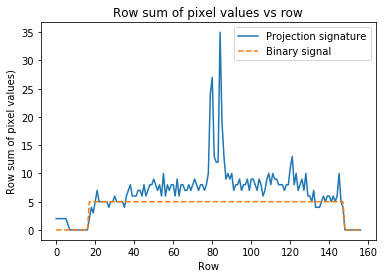

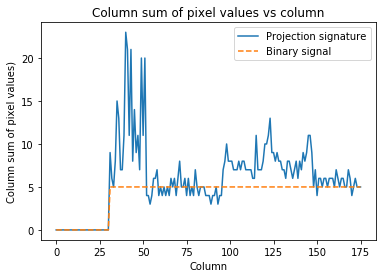

Ground truth region 0 cropped horizontally
The coverage is: 80.30437903804739


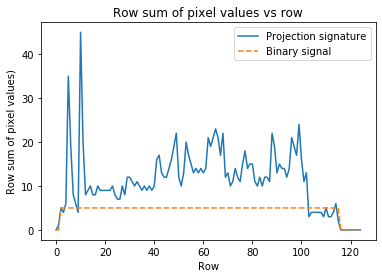

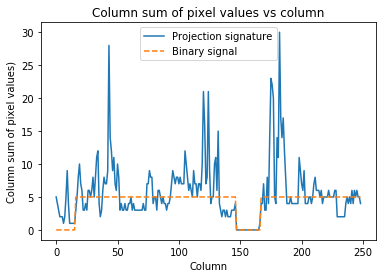

Ground truth region 1 cropped horizontally
The coverage is: 78.53794754163758


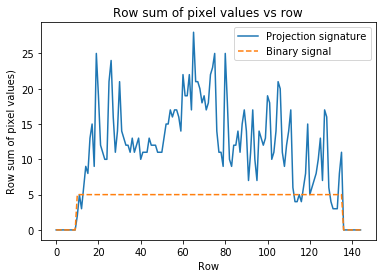

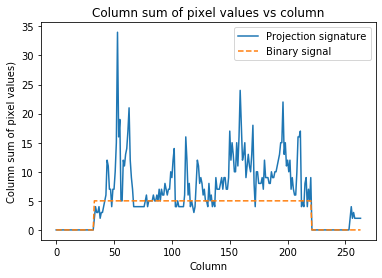

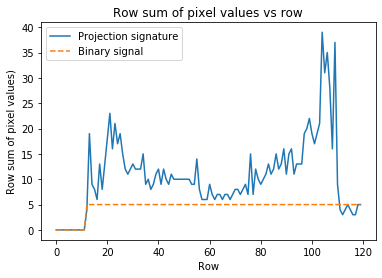

Ground truth region 10 cropped vertically
The coverage is: 70.43738200125865


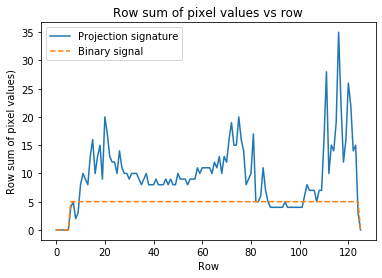

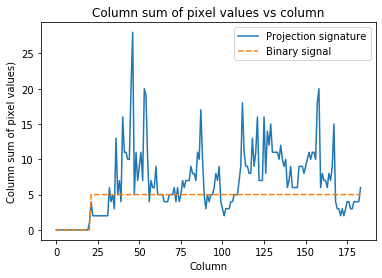

Ground truth region 11 cropped horizontally
The coverage is: 71.509009009009


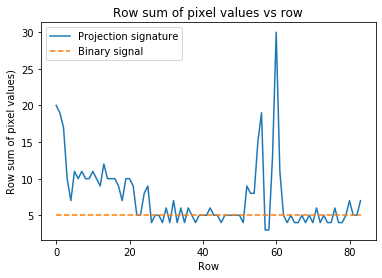

Ground truth region 12 cropped vertically
The coverage is: 40.30346135609293


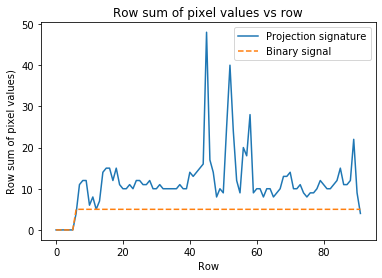

Ground truth region 13 cropped vertically
The coverage is: 70.26148907852502


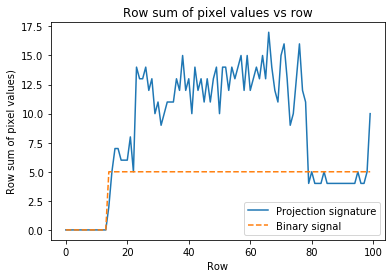

Ground truth region 14 cropped vertically
The coverage is: 60.90860359153042


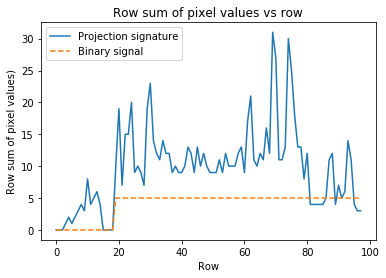

Ground truth region 15 cropped vertically
The coverage is: 48.43444227005871


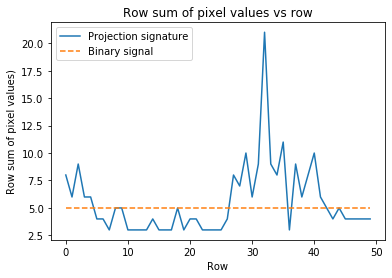

Ground truth region 16 cropped vertically
The coverage is: 11.63279132791328


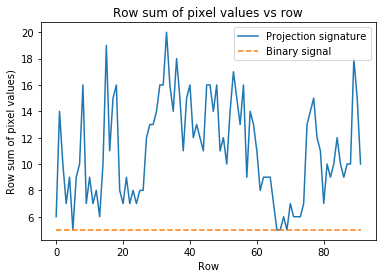

Ground truth region 17 cropped vertically
The coverage is: 37.568529383476005


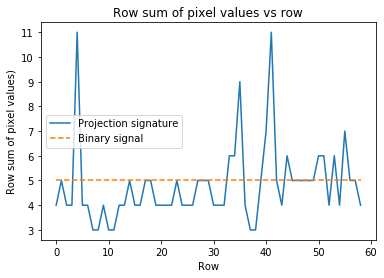

Ground truth region 18 cropped vertically
The coverage is: 23.09558466763707


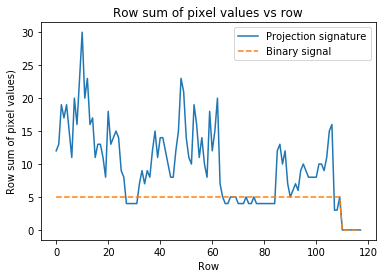

Ground truth region 19 cropped vertically
The coverage is: 88.14814814814815


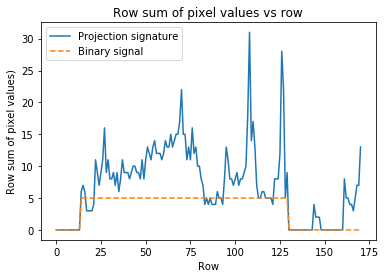

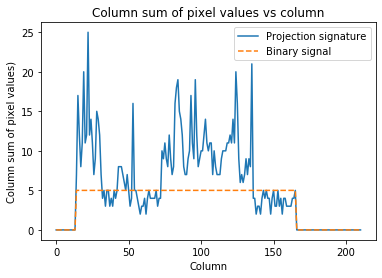

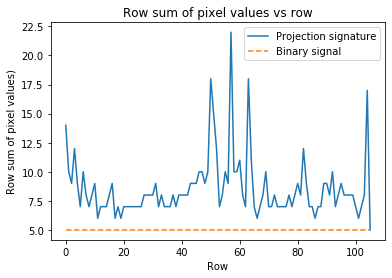

Ground truth region 23 cropped vertically
The coverage is: 69.93464052287581


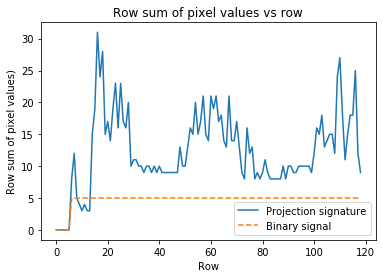

Ground truth region 24 cropped vertically
The coverage is: 63.11089059786653


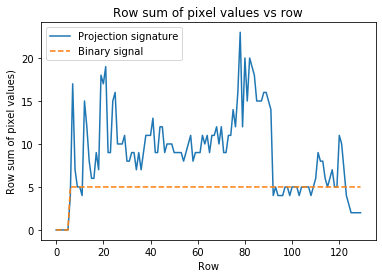

Ground truth region 25 cropped vertically
The coverage is: 78.65964712578258


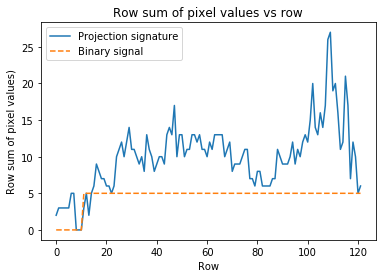

Ground truth region 26 cropped vertically
The coverage is: 89.4443882198158
0 missed
16 cropped
11 successes

The total number of 70-89 crops: 8
The total number of 60-69 crops: 3
The total number of 1-59 crops: 5
Calculating the # of false marks
0 are not marks
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/105_11_0103 failed
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/105_11_0103/crop_analysis/ failed

Analysing 105_11_0103
Loading output
Loading Gtruth
Calculating the rate and crop metrics


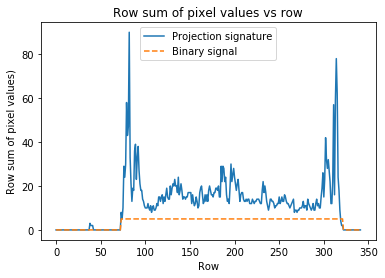

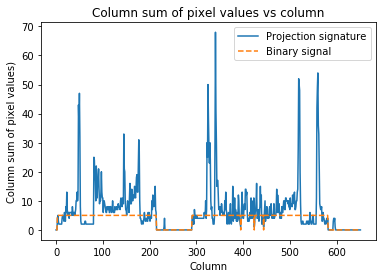

1 missed
0 cropped
1 successes

The total number of 70-89 crops: 0
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0
Calculating the # of false marks
0 are not marks
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/94_20_0059 failed
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/94_20_0059/crop_analysis/ failed

Analysing 94_20_0059
Loading output
Loading Gtruth
Calculating the rate and crop metrics
0 missed
0 cropped
0 successes

The total number of 70-89 crops: 0
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0
Calculating the # of false marks
1 are not marks
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/105_11_0099 failed
Creation of the directory ../../Outputs/MM_seg/753_1588848/model_output_regions/105_11_0099/crop_analysis/ failed

Analysing 105_11_0099
Loading output
Loading Gtruth
Calculating the rate and crop metrics


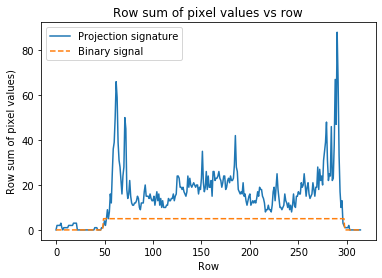

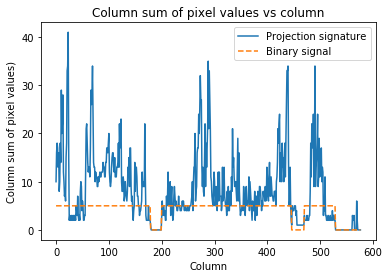

Ground truth region 0 cropped horizontally
The coverage is: 73.78405455191805
0 missed
1 cropped
0 successes

The total number of 70-89 crops: 1
The total number of 60-69 crops: 0
The total number of 1-59 crops: 0
Calculating the # of false marks
0 are not marks


In [57]:
# Cycle through output regions

# Initialise lists and counting variables
gmetrics, ometrics, anomalies, gdb, odb, rdb, totalgm, totalor, crop70, crop60, crop1 = init_metrics()

for x in output:
    
    # Load the original prize paper image
    filename = x[0]
    regions = x[1]
    file_dir = "../../SampleSetsPNG/" + filename + ".png"
    
    crp_analysis_dir = reg_dir + filename 
    create_dir(crp_analysis_dir)
    crp_analysis_dir = crp_analysis_dir + "/crop_analysis/"
    create_dir(crp_analysis_dir)
    
    print('\nAnalysing ' + filename)
    
    ogimg = cv2.imread(file_dir)
    img = cv2.cvtColor(ogimg, cv2.COLOR_BGR2GRAY)
    
    img = cv2.rectangle(img, (0,0), (img.shape[1], img.shape[0]), (0,0,0), -1)
    
    # Plotting the output onto the image
    print("Loading output")
    
    for region in regions:
        # NOTE rectangle uses BGR
        img = cv2.rectangle(img, region[3], region[1] , 1, -1)
    
    # Plotting the ground truth onto the image
    print("Loading Gtruth")
    # Find the index of the page in gtruth list
    index = 0
    for page in gtruth:
        if page[0] == filename:
            break
        index += 1
    
    # Add the ground truth to the analysis images
    # NOTE opencv uses BGR
    gregions = []
    if index == len(gtruth):
        # This is the case when the page has no merchant marks in the ground truth
        pass
    else:
        gregions = gtruth[index][2]
        for region in gregions:
            for x in range(region[0],region[0]+region[2]):
                for y in range(region[1],region[1]+region[3]):
                    img[y][x] += 2
    
    # Tracking the total number of gtruth regions and output regions
    totalgm += len(gregions)
    totalor += len(regions)
                    
    # Calculate the missing marks percentage (misses), successfully extracted (succ) and cropped (cropped)
    print("Calculating the rate and crop metrics")
    
    succ, cropped, misses, crop7089, crop6069, crop159 = rate_crop_analyse(img, ogimg, index, gtruth, gregions)

    print(str(misses) + " missed")
    print(str(cropped) + " cropped")
    print(str(succ) + " successes")
    
    print("\nThe total number of 70-89 crops: "+ str(crop7089))
    print("The total number of 60-69 crops: "+ str(crop6069))
    print("The total number of 1-59 crops: "+ str(crop159))
    
    if cropped != 0:
        # Calculate the crop rate for each percentage wrt cropped images
        crop7089 = crop7089/cropped
        crop6069 = crop6069/cropped
        crop159 = crop159/cropped

        # store the crop statistics
        crop70.append(crop7089)
        crop60.append(crop6069)
        crop1.append(crop159)
    
    print("Calculating the # of false marks")
    # Calculate the accuracy (Whether the identified output region is a mark or not)
    correct = accuracy(regions)
    
    # If there is no ground turth but a false detection
    if len(gregions) == 0 and len(regions) != 0:
        anomalies.append([filename])
        # store the region metrics
        ometric = [correct/len(regions)]
        ometrics.append(ometric)
        odb.append([filename, ometric])
        
    # If there is no gtruth and no detections
    elif len(gregions) == 0 and len(regions) == 0:
        anomalies.append([filename])
        
    else:
        # Create the metrics
        gmetric = [succ/len(gregions), cropped/len(gregions), misses/len(gregions)]
        ometric = [correct/len(regions)]
        
        # store the metrics
        gmetrics.append(gmetric)
        ometrics.append(ometric)
        
        # store the metrics to create a dict later
        gdb.append([filename, gmetric])
        odb.append([filename, ometric])
        

## Store metrics in CSV files

In [58]:
fname = []
success = []
cropped = []
missed = []
correct = []

# The success, cropped, misses
print("Total number of analysed pages: " + str(len(gdb)))
for page in gdb:
    print(page)
    fname.append(page[0])
    success.append(page[1][0])
    cropped.append(page[1][1])
    missed.append(page[1][2])

# Take an average of the success, cropped, misses
av = np.mean(gmetrics, axis=0)
fname.append("average")
success.append(round(av[0],3))
cropped.append(round(av[1],3))
missed.append(round(av[2],3))
print('The average success, cropped and miss rates are:' + str(av))

# Find out the crop percentages
print("\nThe 70-89 crops: "+ str(np.mean(crop70)))
print("The 60-69 crops: "+ str(np.mean(crop60)))
print("The 1-59 crops: "+ str(np.mean(crop1)))

db_dict = {
    "filename": fname,
    "success rate": success,
    "crop rate": cropped,
    "miss rate": missed
}

greg_analysis = pd.DataFrame(db_dict)
greg_analysis.to_csv(analysis_dir + "rate_analysis_alg.csv")

fname = []
print("\nTotal number of analysed pages: " + str(len(odb)))
for page in odb:
    print(page)
    fname.append(page[0])
    correct.append(page[1])


av = np.mean(ometrics, axis=0)
fname.append("average")
correct.append(round(av[0],3))
# Take an average of the correct identification rate
print('The average success, cropped and miss rates are:' + str(av))

db_dict = {
    "filename": fname,
    "correct locating rate": correct
}

oreg_analysis = pd.DataFrame(db_dict)
oreg_analysis.to_csv(analysis_dir + "acc_analysis_alg.csv")

# The correct identification rate
print("\nThe anomalies are:")
print(anomalies)

Total number of analysed pages: 10
['113_21_0057', [1.0, 0.0, 0.0]]
['114_7_0076', [0.6666666666666666, 0.3333333333333333, 0.0]]
['105_11_0076', [0.6, 0.3333333333333333, 0.06666666666666667]]
['114_7_0078', [0.5526315789473685, 0.42105263157894735, 0.02631578947368421]]
['105_11_0105', [1.0, 0.0, 0.0]]
['105_11_0117', [0.0, 1.0, 0.0]]
['105_11_0077', [0.7142857142857143, 0.2857142857142857, 0.0]]
['114_7_0077', [0.4074074074074074, 0.5925925925925926, 0.0]]
['105_11_0103', [0.5, 0.0, 0.5]]
['105_11_0099', [0.0, 1.0, 0.0]]
The average success, cropped and miss rates are:[0.54409914 0.39660262 0.05929825]

The 70-89 crops: 0.6857142857142857
The 60-69 crops: 0.08035714285714286
The 1-59 crops: 0.23392857142857143

Total number of analysed pages: 11
['113_21_0057', [0.5]]
['114_7_0076', [0.3076923076923077]]
['105_11_0076', [1.0]]
['114_7_0078', [1.0]]
['105_11_0105', [1.0]]
['105_11_0117', [1.0]]
['105_11_0077', [1.0]]
['114_7_0077', [1.0]]
['105_11_0103', [1.0]]
['94_20_0059', [0.0]]
